## Load fuctions and libraries

In [229]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

In [230]:
def perform_clustering(corr, clusters = None, limit = 0.8):
    if clusters is None:
        corr = 1 - abs(corr)
        clusters = list(map(lambda x: [x], corr.columns))
    max_val = 1 - limit
    cl = []
    for i in range(len(clusters)-1):
        for j in range(i+1, len(clusters)):
            avg_dist = 0
            for el1 in clusters[i]:
                for el2 in clusters[j]:
                    avg_dist += corr[el1][el2]
            avg_dist /= len(clusters[i])*len(clusters[j])
            if avg_dist <= max_val:
                max_val = avg_dist
                cl = [i,j]
    if len(cl)>1:
        clusters[cl[0]] += clusters[cl[1]]
        del clusters[cl[1]]
        clusters = perform_clustering(corr, clusters, limit)
    return clusters
    
def elect_members(corr, clusters):
    members = []
    corr = 1 - abs(corr)
    for cl in clusters:
        min_v = 0
        element = cl[0]
        if len(cl)!=1:
            for el1 in cl:
                v = 0            
                for el2 in cl:
                    v+=corr[el1][el2]
                if v >= min_v:
                    min_v = v
                    element = el1
        members.append(element)
    return members

def plot_confusion_matrix(y_true, y_pred):
    plt.figure(figsize=(8, 8))
    cf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt=".2f")
    ax.set_title('PD Classification Confusion Matrix\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('\nActual Values ')
    ax.xaxis.set_ticklabels(['No Tornado', 'Tornado'])
    ax.yaxis.set_ticklabels(['No Tornado', 'Tornado'])
    plt.show()

def plot_roc(y_actual, y_pred):
    
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    plt.figure(figsize=(8, 5))

    plt.plot(fpr, tpr, color='b', label=r'Mean ROC (Gini = %0.2f)' % (2 * roc_auc_score(y_actual, y_pred) - 1), lw=2, alpha=.8)
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('PD Model ROC')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

## Look at data

In [193]:
train_raw = pd.read_excel('trainingSet.xls')
test_raw  = pd.read_excel('testSet.xls')
train_raw.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V42,V43,V44,V45,V46,V47,V48,V49,V50,Target
0,1,3995,6352,2,3253,9453,7033,8,9,7033,...,1810,12810,204,103,560,2055,39,211,175,1
1,1,3272,8561,2,2933,3194,6203,9,11,8929,...,2214,13566,235,190,482,1536,120,159,177,1
2,1,519,10595,8,3946,10776,6129,19,28,3545,...,2191,13534,230,216,428,1734,77,179,173,1
3,1,650,6632,5,6806,6806,650,18,22,2500,...,1988,13378,230,213,420,1717,72,178,173,1
4,1,1114,9442,5,2628,9779,6660,16,24,2544,...,1432,12904,234,211,338,1750,50,184,172,1


There are lot of features. Maybe too much. some method of dimensionality reduction should be considered. I will do PCA.

In [194]:
len(train_raw.columns)

51

We have no null values. Therefore, data imputation will not be necessary. 

In [148]:
train_raw.isna().sum().sum()

0

Dataset is heavily unbalanced. I will oversample the target class because otherwise, if I understandble the non-target class, the training data will only consist of 2*75 observation.

In [149]:
train_raw[['Target']].value_counts()

Target
-1        967
 1         75
dtype: int64

Making the targets to 0 an 1

In [195]:
train_raw.loc[train_raw['Target'] == -1, 'Target'] = 0

## Balance the training data

In [196]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = train_raw[train_raw.Target==0]
df_minority = train_raw[train_raw.Target==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Target.value_counts()

0    967
1    967
Name: Target, dtype: int64

## PCA

### getting rid of correlation

<AxesSubplot:>

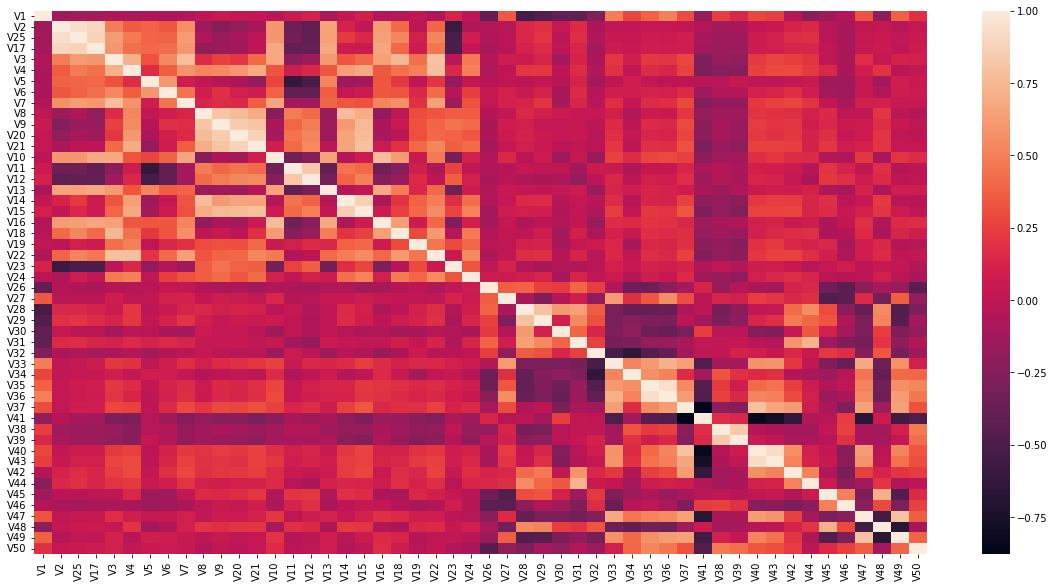

In [197]:
corr_train = df_upsampled.drop('Target', axis=1).corr()
clusters   = perform_clustering(corr_train)
order      = [inner for outer in clusters for inner in outer]

plt.figure(figsize=(20,10))
sns.heatmap(df_upsampled[order].corr())

<AxesSubplot:>

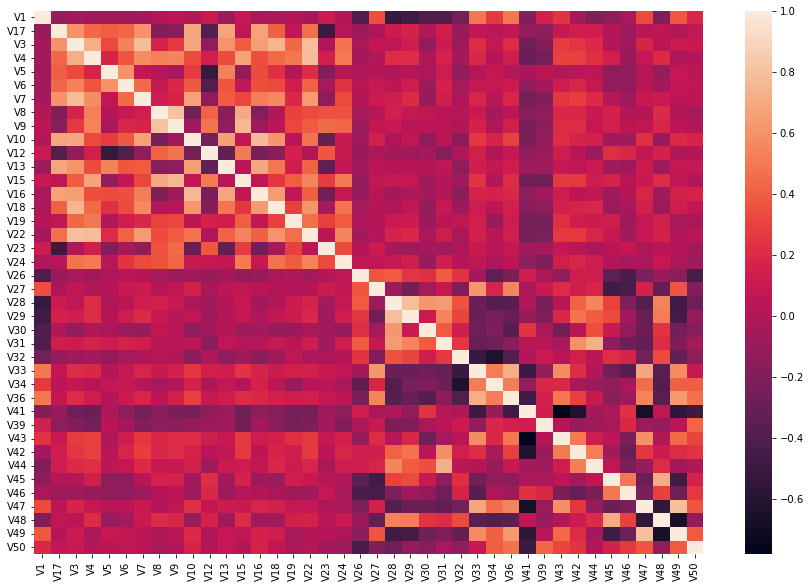

In [198]:
members = elect_members(corr_train, clusters)
df_upsampled_nocorr = df_upsampled[members]
plt.figure(figsize=(15,10))
sns.heatmap(df_upsampled_nocorr.corr())

### Standartization

In [200]:
from sklearn.preprocessing import MinMaxScaler

In [201]:
minmax_scalar  = MinMaxScaler()
scaled_members = minmax_scalar.fit_transform(df_upsampled_nocorr) 

### PCA applied

In [202]:
from sklearn.decomposition import PCA

In [203]:
pca_object          = PCA(.90)
principalComponents = pca_object.fit_transform(scaled_members)
print('The total number of principal components is', principalComponents.shape[1])

The total number of principal components is 17


In [204]:
columns_names = ['principal component' + str(i+1) for i in range(principalComponents.shape[1])]
principalDf = pd.DataFrame(data = principalComponents, columns = columns_names)

targets = df_upsampled[['Target']]
targets.reset_index(inplace=True)

finalDf = pd.concat([principalDf, targets], axis = 1)
finalDf.drop('index', axis=1, inplace=True)

We can observe that the principal components somehow managed to seperate the data

<AxesSubplot:xlabel='principal component1', ylabel='principal component3'>

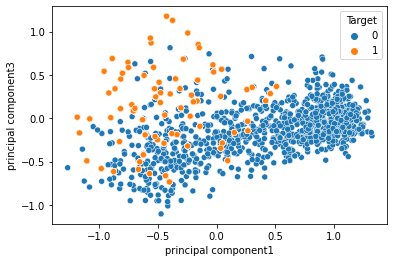

In [207]:
sns.scatterplot(data=finalDf, x='principal component1', y='principal component3', hue='Target')

## Train test Split

In [209]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(finalDf.drop('Target', axis=1),
                                                    finalDf.Target,
                                                    test_size=0.2,
                                                    #stratify makes porportion of equal in test and train set
                                                    stratify=finalDf.Target,
                                                    shuffle=True)

## Models

### Logistic regression

In [275]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logit = LogisticRegression(multi_class='ovr', max_iter=1000)

logit_grid   = GridSearchCV(logit, {'C': [1, 5, 10, 15, 20],
                                    'penalty' : ['l2']}, 
                            cv=10,
                            return_train_score=False)

In [276]:
logit_grid.fit(X_train, y_train)
logit_grid.best_params_

{'C': 10, 'penalty': 'l2'}

In [277]:
logit_grid.score(X_test,y_test)

0.8552971576227391

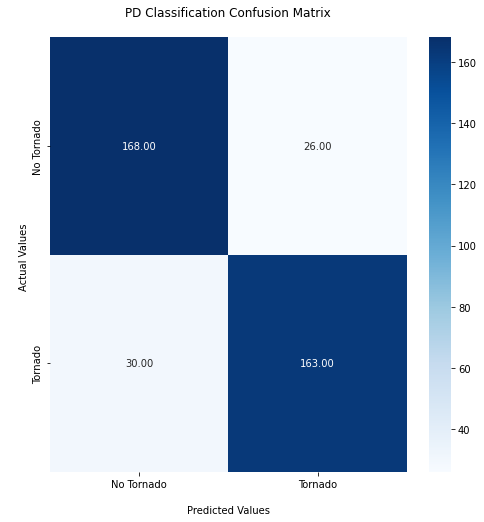

In [278]:
plot_confusion_matrix(y_test, logit_grid.predict(X_test))

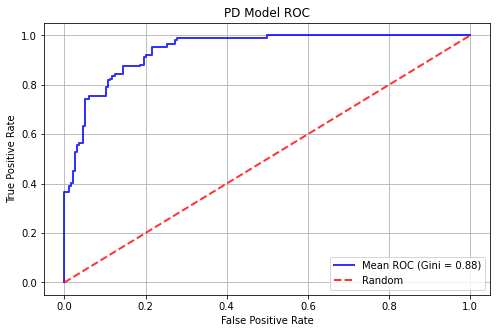

In [282]:
plot_roc(y_test, logit_grid.predict_proba(X_test)[:,1])

### SVM

In [261]:
from sklearn.svm import SVC

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.05, 0.1, 1]}

SVM_grid = GridSearchCV(SVC(probability=True), param_grid, cv=10, verbose = 1)

In [262]:
SVM_grid.fit(X_train, y_train)
SVM_grid.best_params_

Fitting 10 folds for each of 25 candidates, totalling 250 fits


{'C': 10, 'gamma': 1}

In [263]:
SVM_grid.score(X_test,y_test)

0.9870801033591732

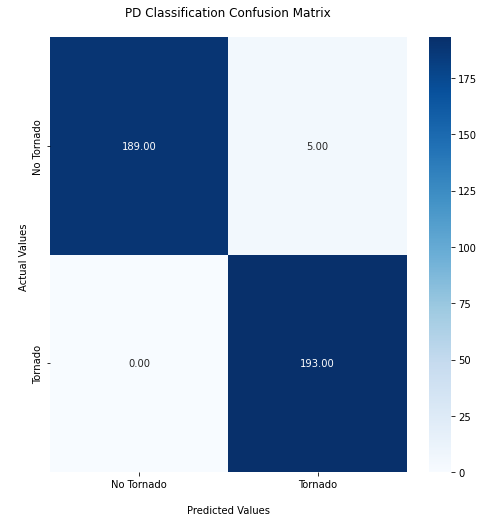

In [227]:
plot_confusion_matrix(y_test, SVM_grid.predict(X_test))

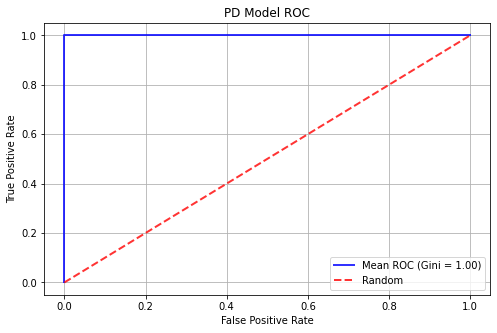

In [280]:
plot_roc(y_test, SVM_grid.predict_proba(X_test)[:,1])

### KNN

In [216]:
from sklearn.neighbors import KNeighborsClassifier

In [217]:
grid_parms = {
    'n_neighbors': [3,5,11,19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

Knn_grid = GridSearchCV(KNeighborsClassifier(), grid_parms, cv=5, )

In [218]:
Knn_grid.fit(X_train, y_train)
Knn_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [219]:
Knn_grid.score(X_test,y_test)

0.979328165374677

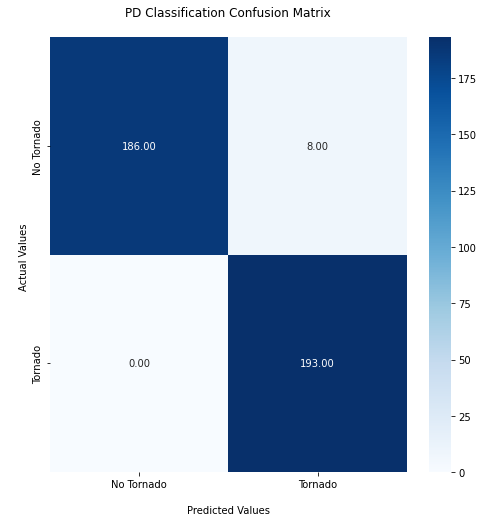

In [228]:
plot_confusion_matrix(y_test, Knn_grid.predict(X_test))

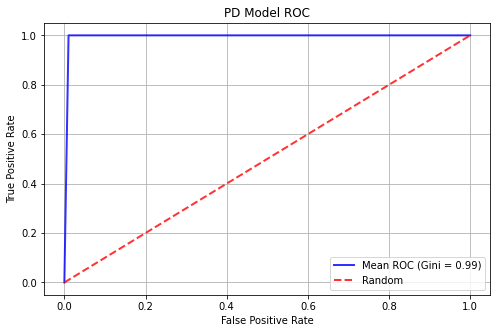

In [283]:
plot_roc(y_test, Knn_grid.predict_proba(X_test)[:,1])

## Which model should be selected?

First of all, I am pretty sure, that there is overfitting in the model. Otherwise, I can't explain the result of almost 100% correct predictions. However, I tried with GrindSearchCV to oppose overfitting, as in GrindSearchCV we have k-fold which already helps.

As we are dealing with a natural catastrophe, we should make sure that we never classify a no-tornada, when there actually is a tornado! Therefore, We should eighter take the SVM or the KNN. 

However, the SVM also has less "false alarm" (False positive) classifications. Therefore, should consider the SVM as the model to go with. Also by the ROC AUC we see that the value is higher. Therefore, I chose the SV as my model.

## Predict Test Data

In [285]:
SVM_grid.predict(pca_object.transform(minmax_scalar.transform(test_raw[members])))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1])